In [1]:
import tensorflow as tf

if tf.test.gpu_device_name():
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
else:
    print("Please install GPU version of TF")

Default GPU Device: /device:GPU:0


In [2]:
import time 

## 신경망 스타일 전이 

유명한 그림의 스타일을 모방해 사용자의 콘텐츠, 즉  
사진을 재구성하는 것 : `신경망 스타일 전이(Neural Style Transfer)`

사용자 사진에 대한 이렇나 작업을 실시간으로 처리하는 앱 예시 : Prisma  
이 기법의 작동 원리를 살펴 보자. 

딥러닝 : 저수준 특성(픽셀 값 등)에서 고수준 특성을 추출하는 심층 신경망을 구축하는 것이 포함됨 

모델 : 픽셀들이 모여 모서리, 곡면, 평면을 형성한다 -> 사진의 여러 양상을 학습하게 된다. 

그림을 디지털화한 이미지에서 신경망 학습 -> 화가가 그림을 그리기 위한 붓터치 학습 

기본 발상 : CNN과 같은 심층 신경망들의 특성 층들을 사용해  
두 이미지 사이의 스타일 거리와 콘텐츠 거리 계산 

> **STEP 1**  
-아키텍처 : ImageNet에서 훈련된 VGG19 모델 사용할 예정 

In [3]:
# ImageNet에서 사전 훈련된 모델을 keras에서 로드 
vgg19 = tf.keras.applications.vgg19.VGG19(include_top=False, weights='imagenet')
vgg19.trainable=False
vgg19.summary()

Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0     

> **STEP 2**
- 스타일 및 콘텐츠 층으로 사용할 특정 특성 층 선택  
- vgg19 모델이 이미지에서 학습한 특성들을 추출하는 데 사용될 것 

최적화를 수행할 것이므로, 우리의 목적 : 스타일 및 콘텐츠 거리를 최소화시키는 것 

콘텐츠 비교 : block_5의 conv 층 활용  
스타일 비교 : 여러 개의 conv 층 활용  
-> 이러한 층들만을 반환하는 style_model이라는 새로운 모델 구축 

In [4]:
# 특성 맵들을 끌어낼 콘텐츠 층
content_layers = ['block5_conv2']

# 관심 대상인 스타일 층 
style_layers = [
    'block1_conv1', 
    'block2_conv1',
    'block3_conv1',
    'block4_conv1',
    'block5_conv1'
]

# 스타일 및 콘텐츠 층의 수 계산 
num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

In [5]:
# 스타일 및 콘텐츠 층에 해당하는 출력 층 가져오기 
style_outputs = [vgg19.get_layer(name).output for name in style_layers]
content_outputs = [vgg19.get_layer(name).output for name in content_layers]
model_outputs = style_outputs + content_outputs # content_outputs의 vgg19 모델 상 순서가 style_outputs 뒤에 있기 때문 

In [7]:
# build model 
style_model = tf.keras.models.Model(vgg19.input, model_outputs)

> **STEP 3:**  
- 두 개의 이미지를 내려받는다. 하나는 콘텐츠를 위한 이미지, 하나는 스타일을 위한 이미지 
- 다운받는 링크 만료되어서 그냥 이미지 내가 원하는 거 찾아서 받기 
- 콘텐츠 위한 이미지 : 배경없는 정국 이미지 (mycontent.jpg/png)
- 스타일 위한 이미지 : 반 고흐 - 별이 빛나는 밤에 이미지 (mystyle.jpg/png)

In [8]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [9]:
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg19 import preprocess_input

In [10]:
content_path ='mycontent.png'
style_path = 'mystyle.jpg'

In [11]:
# 콘텐츠 및 스타일 이미지를 메모리에 로드 
content = image.load_img(content_path, target_size=(224, 224))
style = image.load_img(style_path, target_size=(224, 224))

In [12]:
print(type(content), type(style))

<class 'PIL.Image.Image'> <class 'PIL.Image.Image'>


In [14]:
content_temp = image.load_img('mycontent1.png', target_size=(224, 224))
content_temp = image.img_to_array(content)
print(np.mean(content_temp[:, :, 0]), np.mean(content_temp[:, :, 1]), np.mean(content_temp[:, :, 2]))

162.63731 161.25945 166.47707


In [15]:
style_temp = image.load_img('mystyle.jpg', target_size=(224, 224))
style_temp = image.img_to_array(style_temp)
print(np.mean(style_temp[:, :, 0]), np.mean(style_temp[:, :, 1]), np.mean(style_temp[:, :, 2]))

86.355965 114.34752 126.02535


In [16]:
# 콘텐츠 및 스타일 이미지를 배열로 변환 
content_x = image.img_to_array(content)
print(content_x.shape)
content_x = np.expand_dims(content_x, axis=0)
print("after expand dims:", content_x.shape)
content_x = preprocess_input(content_x)
print("after preprocess_input:", type(content_x), content_x.shape)

style_x = image.img_to_array(style) # PIL.Image.Image.img_to_array -> np.array
print(style_x.shape)
style_x = np.expand_dims(style_x, axis=0)
print("after expand dims:", style_x.shape)
style_x = preprocess_input(style_x)
print("after preprocess_input:", type(style_x), style_x.shape)

(224, 224, 3)
after expand dims: (1, 224, 224, 3)
after preprocess_input: <class 'numpy.ndarray'> (1, 224, 224, 3)
(224, 224, 3)
after expand dims: (1, 224, 224, 3)
after preprocess_input: <class 'numpy.ndarray'> (1, 224, 224, 3)


In [17]:
print(np.mean(style_x[:, :, 0]), np.mean(style_x[:, :, 1]), np.mean(style_x[:, :, 2]))

-15.172844 -16.894571 -17.547844


In [18]:
print(np.mean(content_x[:, :, 0]), np.mean(content_x[:, :, 1]), np.mean(content_x[:, :, 2]))

81.46256 81.129234 81.25275


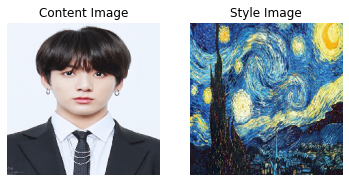

In [19]:
# 로드된 이미지를 표시 
plt.subplot(1, 2, 1)
plt.axis('off')
plt.title('Content Image')
plt.imshow(content)

plt.subplot(1, 2, 2)
plt.axis('off')
plt.title('Style Image')
plt.imshow(style)
plt.show()

> **STEP 4:**  
- 콘텐츠 및 스타일 손실의 계산과 최적화를 위한 경사(gradient) 계산에 사용될 몇 가지 보조함수 

In [32]:
# 몇 가지 보조함수들 

# 모델이 생성한 정규화된 결과값을 실제 픽셀 값으로 구하기 
def deprocess_img(processed_img):
    x = processed_img.copy()
    if len(x.shape) == 4:
        x = np.squeeze(x, 0)
        
    # 선처리 단계를 반대로 수행 
    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68
    x = x[:, :, ::-1]
    
    # 0 이하 255 이상 값 제거 
    x = np.clip(x, 0, 255).astype('uint8')
    return x

# 콘텐츠와 타깃 간의 거리로 콘텐츠 손실을 정의 
def get_content_loss(base_content, target):
    return tf.reduce_mean(tf.square(base_content - target))

# 스타일 손실을 구하기 위해서 먼저 GRAM 행렬을 계산 
def gram_matrix(input_tensor):
    # 우선 이미지 채널을 만든다.
    channels = int(input_tensor.shape[-1])
    a = tf.reshape(input_tensor, [-1, channels])
    n = tf.shape(a)[0]
    # 그램 행렬을 계산하기 위해 행렬을 전치해 행렬곱한다.
    gram = tf.matmul(a, a, transpose_a=True)
    return gram / tf.cast(n, tf.float32)

# 스타일 손실 계산 
def get_style_loss(base_style, gram_target):
    # 주어진 층에서의 손실을 특성 맵 크기의 필터 수로 크기 측정 
    height, width, channels = base_style.get_shape().as_list()
    gram_style = gram_matrix(base_style)
    return tf.reduce_mean(tf.square(gram_style - gram_target))

# 전체 손실 계산 
def compute_loss(model, loss_weights, init_image, gram_style_features, content_features):
    style_weight, content_weight = loss_weights
 
    # 우리 모델은 다른 함수처럼 호출할 수 있다. 
    model_outputs = model(init_image)
    style_output_features = model_outputs[:num_style_layers]
    content_output_features = model_outputs[num_style_layers:]
    style_score = 0
    content_score = 0
 
    # 모든 층들로부터의 스타일 손실을 누적 
    weight_per_style_layer = 1.0 / float(num_style_layers)
    for target_style, comb_style in zip(gram_style_features, style_output_features):
        style_score += weight_per_style_layer * get_style_loss(comb_style[0], target_style)
 
    # 모든 층들로부터의 콘텐츠 손실을 누적 
    weight_per_content_layer = 1.0 / float(num_content_layers)
    for target_content, comb_content in zip(content_features, content_output_features):
        content_score += weight_per_content_layer* get_content_loss(comb_content[0], target_content)
 
    style_score *= style_weight
    content_score *= content_weight
    # 전체 손실 구하기
    loss = style_score + content_score
    return loss, style_score, content_score

In [21]:
# 경사(gradient) 계산 함수
def compute_grads(cfg):
    with tf.GradientTape() as tape:
        all_loss = compute_loss(**cfg)
    # 입력 이미지에 대한 gradient 계산 
    total_loss = all_loss[0]
    return tape.gradient(total_loss, cfg['init_image']), all_loss

# 콘텐츠 및 스타일 특성 표상의 계산 
def get_feature_representations(model, content_path, style_path):
    # 콘텐츠 및 스타일 특성의 배치 계산
    style_outputs = model(style_x)
    content_outputs = model(content_x)
    
    # 우리 모델에서 스타일 및 콘텐츠 특성 표상을 구한다. 
    style_features = [style_layer[0] for style_layer in style_outputs[:num_style_layers]]
    content_features = [content_layer[0] for content_layer in content_outputs[num_style_layers:]]
    return style_features, content_features

# 이미지 함수 표시 
def display_result(p_image):
    plt.figure(figsize=(8, 8))
    plt.axis('off')
    plt.imshow(p_image)
    plt.show()

> **STEP 5:** 
- 스타일 전이 최적화를 수행하기 위해 호출할 주 함수 정의 
- 반복 횟수를 지정하고 콘텐츠와 스타일에 대한 가중치 제공 

In [34]:
# 스타일 전이를 실제 수행할 주 함수
def run_style_transfer(num_iterations=100, content_weight=1e3, style_weight=1e-2):
    # 학습을 하는 것이 아니므로 층들이 학습할 수 없도록 설정 
    model = style_model
    for layer in style_model.layers:
        layer.trainable=False
    
    # (지정한 중간 층들로부터) 스타일 및 콘텐츠 특성 표상 구하기 
    style_features, content_features = get_feature_representations(style_model, content_path, style_path)
    gram_style_features = [gram_matrix(style_feature) for style_feature in style_features]
    
    # 콘텐츠 이미지를 초기 이미지로 설정 
    init_image = content_x.copy()
    init_image = tf.Variable(init_image, dtype=tf.float32)
    # init_image = tfe.Variable(init_image, dtype=tf.float32)
    # Adam Optimizer 구축하기
    opt = tf.keras.optimizers.Adam(learning_rate=0.2, beta_1=0.99, epsilon=1e-1)
    
    # 중간 이미지 표시를 위해
    iter_count = 1
    
    # 최선의 결과 
    best_loss, best_img = float('inf'), None
    
    # 손실 항들을 정의하고 설정 객체를 구축 
    loss_weights = (style_weight, content_weight)
    cfg = {
        "model": style_model,
        'loss_weights': loss_weights,
        "init_image": init_image, 
        "gram_style_features": gram_style_features,
        "content_features": content_features
    }
    
    # 결과 표시
    num_rows = 2
    num_cols = 5
    display_interval = num_iterations / (num_rows * num_cols)
    start_time = time.time()
    global_start = time.time()
    
    # 정규화를 위한 각 채널의 평균 계산 
    norm_means = np.array([103.939, 116.779, 123.68])
    min_vals = -norm_means
    max_vals = 255 - norm_means
    
    # 최적화를 수행하고 중간 생성 이미지 구하기 
    # init_image로 작업하고 최적화를 통해 수정 
    imgs = []
    for i in range(num_iterations):
        grads, all_loss = compute_grads(cfg)
        loss, style_score, content_score = all_loss
        opt.apply_gradients([(grads, init_image)])
        clipped = tf.clip_by_value(init_image, min_vals, max_vals)
        init_image.assign(clipped)
        end_time = time.time()
        
        if loss < best_loss:
            # 전체 손실로부터 최선의 손실과 최선의 이미지 업데이트
            best_img = deprocess_img(init_image.numpy())
            
        if i % display_interval == 0:
            start_time = time.time()
            # 이미지 제목 정하기 
            print("Iteration: {}".format(i))
            print("Total loss: {:.4e}".format(loss))
            print("style loss: {:.4e}".format(style_score))
            print("content loss: {:4e}".format(content_score))
            print("time: {:.4f}s".format(time.time() - start_time))
            
            # numpy() 메소드를 사용해 구체적인 numpy 배열 구하기 
            plot_img = init_image.numpy()
            plot_img = deprocess_img(plot_img)
            display_result(plot_img)
    
    print("Total Time: {:.4f}s".format(time.time() - global_start))
    return best_img, best_loss

> **STEP 6:**  
- 실제 최적화 위해 코드 실행하고 원래 콘텐츠 사진이 어떻게 변했는지 보자. 

Iteration: 0
Total loss: 1.0827e+09
style loss: 1.0827e+09
content loss: 0.000000e+00
time: 0.0007s


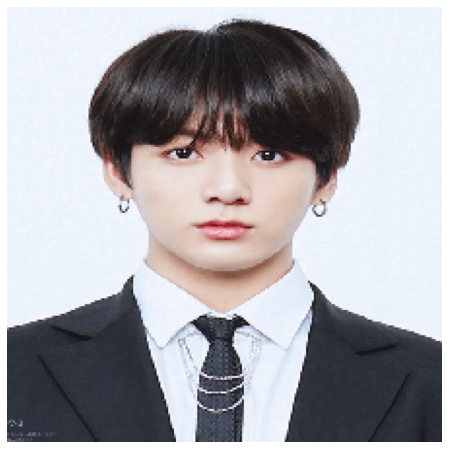

Iteration: 2
Total loss: 1.0327e+09
style loss: 1.0326e+09
content loss: 7.359986e+04
time: 0.0007s


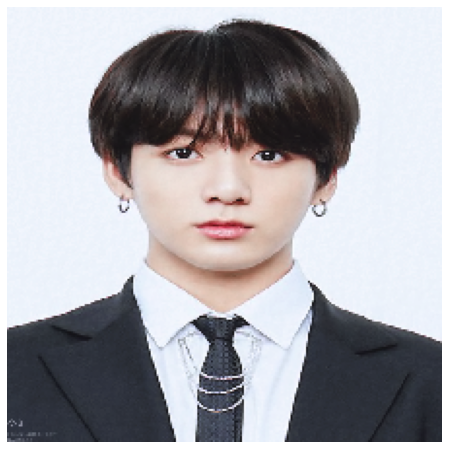

Iteration: 4
Total loss: 9.8809e+08
style loss: 9.8784e+08
content loss: 2.556341e+05
time: 0.0007s


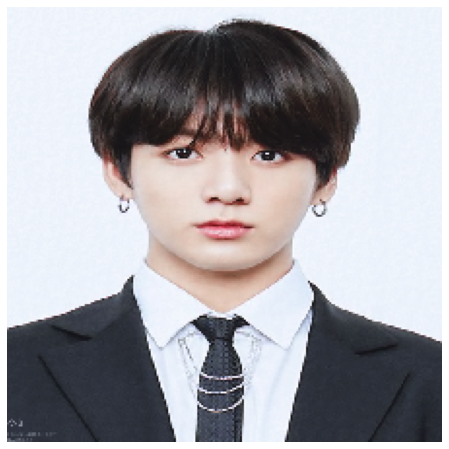

Iteration: 6
Total loss: 9.4774e+08
style loss: 9.4730e+08
content loss: 4.457366e+05
time: 0.0008s


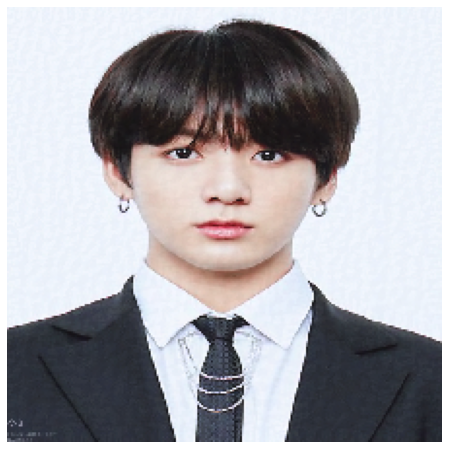

Iteration: 8
Total loss: 9.1033e+08
style loss: 9.0970e+08
content loss: 6.290802e+05
time: 0.0007s


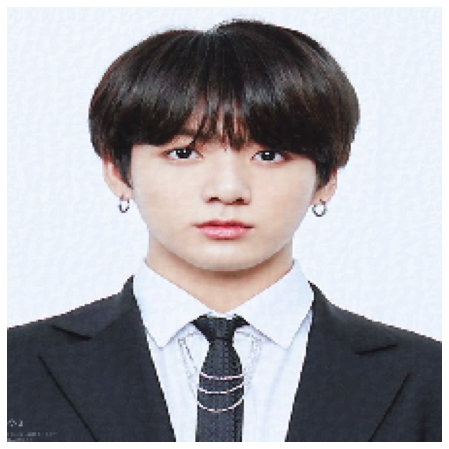

Iteration: 10
Total loss: 8.7476e+08
style loss: 8.7395e+08
content loss: 8.059542e+05
time: 0.0008s


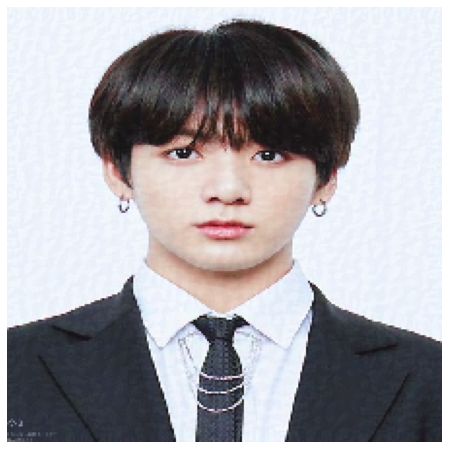

Iteration: 12
Total loss: 8.4120e+08
style loss: 8.4023e+08
content loss: 9.734060e+05
time: 0.0007s


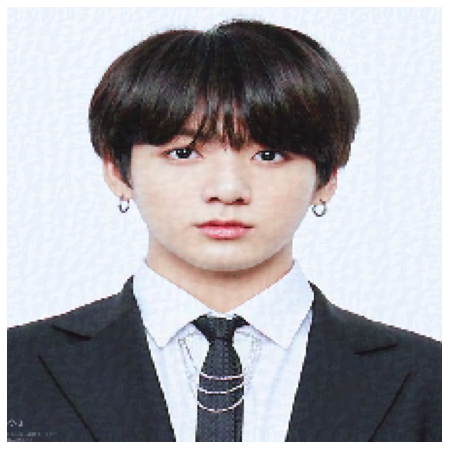

Iteration: 14
Total loss: 8.0870e+08
style loss: 8.0757e+08
content loss: 1.129915e+06
time: 0.0012s


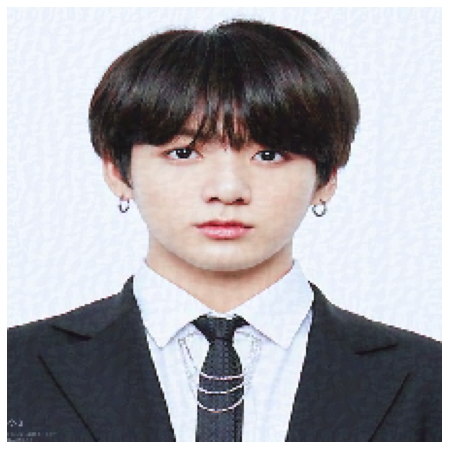

Iteration: 16
Total loss: 7.7698e+08
style loss: 7.7570e+08
content loss: 1.277434e+06
time: 0.0007s


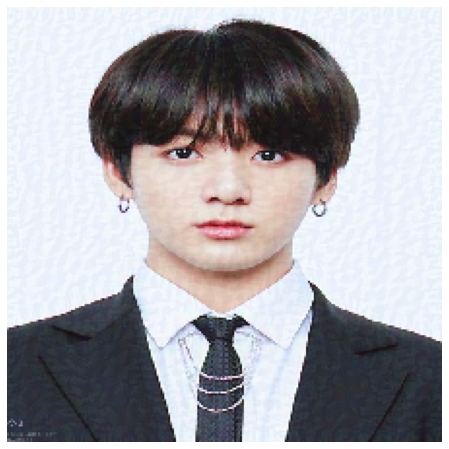

Iteration: 18
Total loss: 7.4613e+08
style loss: 7.4471e+08
content loss: 1.417609e+06
time: 0.0007s


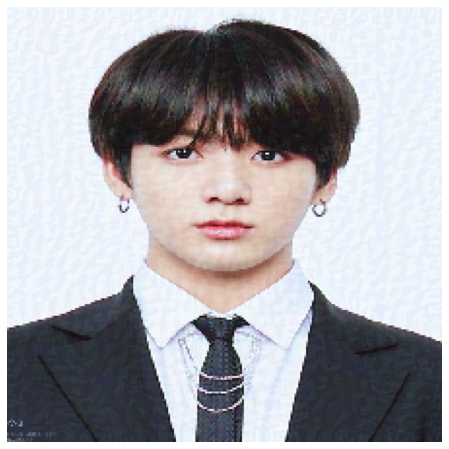

Total Time: 2.4554s


In [35]:
best, best_loss = run_style_transfer(num_iterations=20)

https://colab.research.google.com/drive/1_tHUYgO_fIBU1JXdn_mXWCDD6njLyNSu